# 🐶End-to-end Multiclass Dog Breed Classification

This notebook builds an end-to-end multi class image classifier using Tensorflow 2.x and Tensorflow Hub.

## 1. Problem

Identify the breed of the dog by the given image of the dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.


## 2. Data


The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data


## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation


## 4. Features

Some features about data:
* We're are dealing with images (unstructured data) so it's probably best to use deep learning/ transfer learning.
* There are 120 different breeds of dogs (This means there are 120 different classes).
* There are 10,000+ images in the  training set (these images have labels).
* There are 10,000+ images in the test set (these images have no labels since we'll be predicting  




In [1]:
# Unzip the data
# !unzip "/content/drive/MyDrive/Colab Notebooks/Dog Vision /dog-breed-identification.zip" -d "/content/drive/MyDrive/Colab Notebooks/Dog Vision "

## Get our workspace ready

- Import Tensorflow 2.x ✅
- Import Tensorflow Hub ✅
- Make sure we're using a GPU ✅

In [2]:
# Import Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
print("Tensorflow version:", tf.__version__)
print("Tensorflow_hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YES!)" if tf.config.list_physical_devices("GPU") else
      "not available :(")

Tensorflow version: 2.15.0
Tensorflow_hub version: 0.16.1
GPU available (YES!)


## Getting our data ready (turning into tensors)

With all machine learning models, our data  has to be in numerical format.So that's what we will be doing first.Turning our images into Tensors(numerical representation).

Let's start by accessing our data and checking out the labels.

In [3]:
# check out the label of the data

import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dog Vision/labels.csv")
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


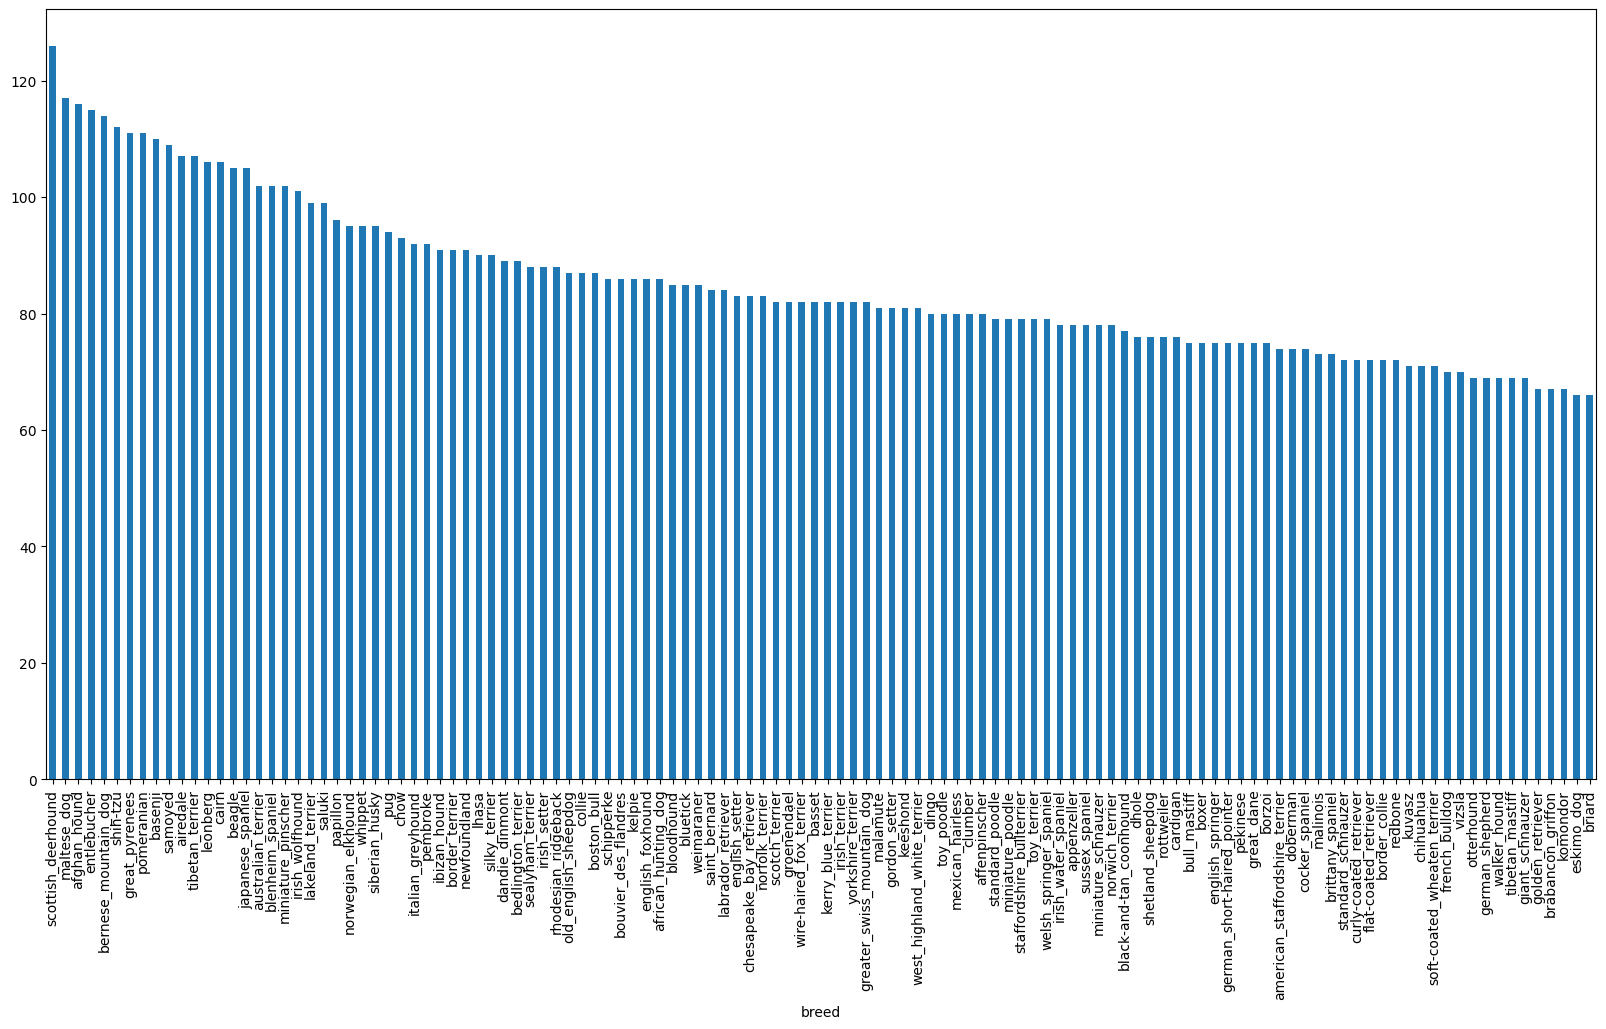

In [5]:
# how many images are there in each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [6]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

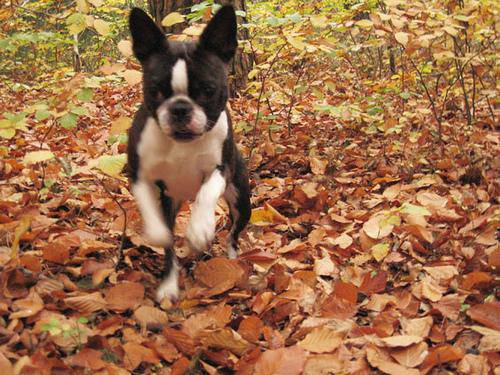

In [7]:
# lets view an image
from IPython.display import Image
Image("/content/drive/MyDrive/Colab Notebooks/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting Images and their labels

Let's get a list of all our images file pathnames.

In [8]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
# Creat a path name for image Id's

filenames = ["drive/MyDrive/Colab Notebooks/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv[ "id"]]

# Check for forst 10 rows
filenames[:10]

['drive/MyDrive/Colab Notebooks/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# Check whether number of filenames matches number of actual image files

import os
if len(os.listdir("/content/drive/MyDrive/Colab Notebooks/Dog Vision/train")) == len(filenames):
  print("Filename matches actual number of files ! Proceed.")
else:
  print("File name not matched check target directory")


Filename matches actual number of files ! Proceed.


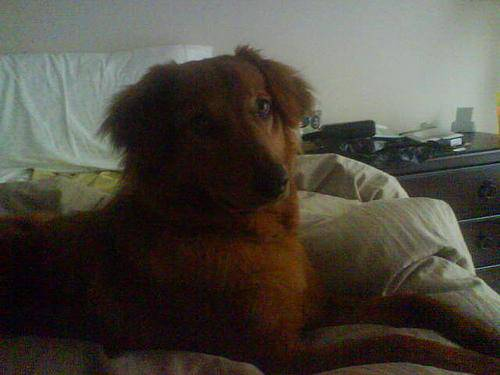

In [11]:
# one miore check
Image(filenames[1000])

In [12]:
labels_csv["breed"][1000]

'irish_setter'

Since we got our training image filepaths in a list,let's prepare our list.

In [13]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# See if the number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("The number of labels matches the number of filenames")
else:
  print("Number of labels does not matches the number of filenames, check the data directories")

The number of labels matches the number of filenames


In [16]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [17]:
# Turn a single label into am array of booleans
print(labels[0])
labels[0] == unique_breeds


boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [18]:
len(labels)

10222

In [19]:
# Turn every label into boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels)

10222

In [21]:
# Example: Turning boolean numbers into integers
print(labels[0]) # orginal label
print(np.where(unique_breeds==labels[0])) # index where the label occurs
print(boolean_labels[0].argmax()) # index where the label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [22]:
print(labels[1])
print(boolean_labels[1].astype(int))

dingo
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [23]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [24]:
filenames[:10]

['drive/MyDrive/Colab Notebooks/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

# Creating our own validation set
Since the dataset from kaggle does'nt come with validation set,we're going to create our own.

In [25]:
# setup x and y variables
x = filenames # our data (images)
y = boolean_labels # labels of the images in boolean

In [26]:
len(filenames)

10222

We're going to strt off with ~1000 images and increase as needed.

In [27]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider",min:1000,max:10000,step:1000}

In [28]:
# let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# split the data into train and validation set of total NUM_IMAGES size
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(x_train), len(x_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [29]:
# let's check
x_train[:5],y_train[:2]

(['drive/MyDrive/Colab Notebooks/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Colab Notebooks/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Colab Notebooks/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Colab Notebooks/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Colab Notebooks/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False,

## Preprocessing Images (turning images into Tensors)

To Preprocess our images into Tensor's we're going to write a function that does a few things.

1. Take an image file as input.
2. Use TensorFlow to read the file and save it to a variable,`image`
3. Turn our `image` (a jpg) into tensors
4. Normalize our image (convert colour channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224,224).
6. Return the modified `image`.

Before we do,let's see how does an image look like when we import it.


In [30]:
# Convert image into numpy array
from matplotlib.pyplot import imread
image = imread(filenames[20])
image.shape # return height,width,colour channel number(RGB)

(375, 500, 3)

In [31]:
image[:2]

array([[[127, 128, 120],
        [123, 124, 116],
        [117, 120, 111],
        ...,
        [ 98, 123,  65],
        [ 97, 122,  64],
        [102, 127,  69]],

       [[117, 120, 111],
        [114, 117, 108],
        [112, 115, 106],
        ...,
        [ 97, 123,  62],
        [ 94, 119,  61],
        [ 98, 124,  63]]], dtype=uint8)

In [32]:
# turn image into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[127, 128, 120],
        [123, 124, 116],
        [117, 120, 111],
        ...,
        [ 98, 123,  65],
        [ 97, 122,  64],
        [102, 127,  69]],

       [[117, 120, 111],
        [114, 117, 108],
        [112, 115, 106],
        ...,
        [ 97, 123,  62],
        [ 94, 119,  61],
        [ 98, 124,  63]]], dtype=uint8)>

Now we have seen what an image looks like as a Tensor,let's make a function to preprocess them.

We'll create a function to.


1. Take an image file as input.
2. Use TensorFlow to read the file and save it to a variable,`image`
3. Turn our `image` (a jpg) into tensors
4. Normalize our image (convert colour channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224,224).
6. Return the modified `image`.

More information on loading images in TensorFlow can be seen here: https://www.tensorflow.org/tutorials/load_data/images


In [33]:
# Define a image size
IMG_SIZE = 244

# Create a function for preprocessing images
def process_image(img_path,img_size = IMG_SIZE):
  """
  Take an image file path and converts the image into Tensor
  """

  # Read in an image file
  image = tf.io.read_file(img_path)
  # Turn the jpg image into Numerical Tensor with 3 colour channels (Red,Green,Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert colour channel values from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to desired value (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


## Turn our data into batches

why should we turn our data into batches?

Let's say you're trying to process 10,000+ images in one go.They all might not fit into memory(GPU shortage occur).

So that's why we do 32(batch size) images at a time (you can manually adjust the batch size if needed).

In order to use Tensorflow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`.

In [34]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image,label).
  """
  image = process_image(image_path)
  return image, label

In [35]:
# Demo of the above
(process_image(x[42],  tf.constant(y[42])))

<tf.Tensor: shape=(244, 244, 3), dtype=float32, numpy=
array([[[0.33240733, 0.528404  , 0.32877645],
        [0.26302028, 0.454124  , 0.25184554],
        [0.24322662, 0.43179044, 0.22709224],
        ...,
        [0.29380426, 0.52090865, 0.32451057],
        [0.29776222, 0.52521324, 0.33200315],
        [0.29484236, 0.5222934 , 0.33405805]],

       [[0.26853722, 0.46210465, 0.27810386],
        [0.24625303, 0.4426449 , 0.25299522],
        [0.2679708 , 0.4562061 , 0.2626349 ],
        ...,
        [0.28107235, 0.50784814, 0.3127341 ],
        [0.28670043, 0.51383805, 0.3265429 ],
        [0.2895012 , 0.5166388 , 0.3293437 ]],

       [[0.21171938, 0.41078815, 0.25436452],
        [0.23509896, 0.43457666, 0.27692637],
        [0.28364372, 0.47278884, 0.3107396 ],
        ...,
        [0.26476204, 0.49106047, 0.3046848 ],
        [0.27449086, 0.4980203 , 0.32259437],
        [0.28086528, 0.5043947 , 0.3289688 ]],

       ...,

       [[0.0082752 , 0.04095767, 0.03440126],
        [0.01

Now we have got a way to turn our data into tuples of Tensors in the form:`(image,label),let's
make a function to turn all of our data (`x` & `y`) into batches.

In [36]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 42

# Create a function to turn dat into batches
def create_data_batches(x,y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):

  """
  Creates batches of data out of image (y) and label (y) pairs.
  Shuffles the data if it's training data and does'nt shuffle if it's validation data.
  Also accepts the data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have any labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Create validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) #labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping the image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image,label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch


In [37]:
# Create training and validation batches
train_data = create_data_batches(x_train,y_train)
val_data = create_data_batches(x_val,y_val,valid_data=True)

Creating training data batches...
Create validation data batches...


In [38]:
# Checkout the differnt attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None))

## Visualizing Data Batches

Our data is now in batches, however these can be a little hard to understand/comprehend,let's visulize them!

In [39]:
import matplotlib.pyplot as plt

# Create a function for viewing images in the data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots(5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid off
    plt.axis("off")

In [40]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

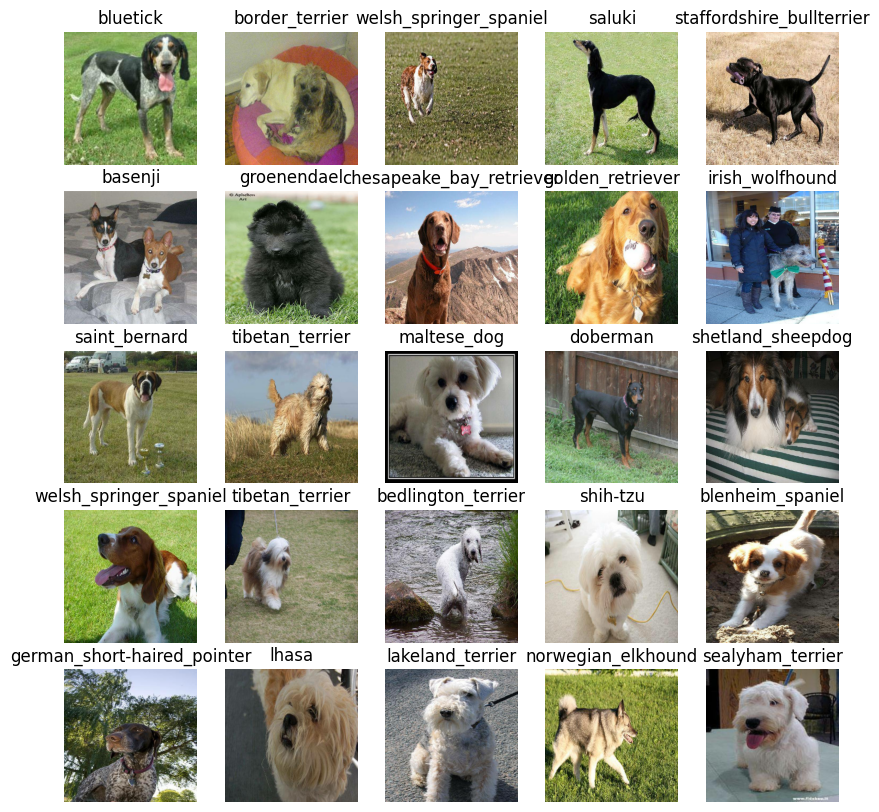

In [41]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [42]:
dataset = tf.data.Dataset.range(2)
for element in dataset:
  print(element)



tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


In [43]:
# # Now let's visualize the data in our validation batch
# val_images, val_labels = next(val_data.as_numpy_iterator())
# show_25_images(train_images, val_labels)

## Building a model

Before we build a model,there are a few things we need to define:

- The input shape (our image shape, in the form of Tensors) to our model.
- The output shape (image labels, in the form of Tensors ) of our model.
- The URL of the model we want to use from Tensorflow Hub - https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification/1?tfhub-redirect=true

In [44]:
IMG_SIZE

244

In [45]:
# setup input shape to the model

# reinstantiate the IMG_SIZE

IMG_SIZE =224

INPUT_SHAPE = [None, IMG_SIZE , IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL form TensorFlow Hub
MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification/1?tfhub-redirect=true"

In [46]:
INPUT_SHAPE

[None, 224, 224, 3]

Now we've have got our inputs,outputs and model ready to go. Let's put them together into keras deep learning model.

Knowing this,let's create a function which:

- Takes the input shape,output shape and the model we've chosen as parameters.
- Defines the layers in a keras model in sequential fashion(do this first,then this,then that)
- Compiles the model (says it should be evaluated and improved).
- Builds the model(tells the model the input shape it'll be getting).
- Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [47]:
# Create a function which builds a keras model

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:",MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                            activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [48]:
model = create_model()
model.summary()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification/1?tfhub-redirect=true
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________
